In [15]:
import pandas as pd

base_path = '../data/cleaned/'

# 1. Load datasets
df_sales = pd.read_csv(f'{base_path}Cleaned_Sales.csv')
df_returns = pd.read_csv(f'{base_path}Cleaned_Returns.csv')
df_products = pd.read_csv(f'{base_path}Cleaned_Products.csv')
df_subcat = pd.read_csv(f'{base_path}Cleaned_Product_Subcategories.csv')

# 2. Map ProductKey to SubcategoryName
product_map = df_products[['ProductKey', 'ProductSubcategoryKey']].merge(
    df_subcat[['ProductSubcategoryKey', 'SubcategoryName']], 
    on='ProductSubcategoryKey', 
    how='left'
)[['ProductKey', 'SubcategoryName']]

# 3. Process Sales (Primary)
sales_processed = df_sales[['OrderDate', 'OrderQuantity', 'ProductKey']].merge(
    product_map, on='ProductKey', how='left'
).groupby(['OrderDate', 'SubcategoryName'])['OrderQuantity'].sum().reset_index()

# 4. Process Returns
returns_processed = df_returns[['ReturnDate', 'ReturnQuantity', 'ProductKey']].merge(
    product_map, on='ProductKey', how='left'
).groupby(['ReturnDate', 'SubcategoryName'])['ReturnQuantity'].sum().reset_index()

# 5. Merge: Left join keeps all sales records
final_df = pd.merge(
    sales_processed, 
    returns_processed, 
    left_on=['OrderDate', 'SubcategoryName'], 
    right_on=['ReturnDate', 'SubcategoryName'], 
    how='left'
)

# 6. Clean Up
final_df['ReturnQuantity'] = final_df['ReturnQuantity'].fillna(0)

# Convert to datetime
final_df['OrderDate'] = pd.to_datetime(final_df['OrderDate'], dayfirst=True)
final_df['ReturnDate'] = pd.to_datetime(final_df['ReturnDate'], dayfirst=True)

# 7. Cut date
final_df = final_df[final_df['OrderDate'] >= '2016-08-01']

# Reorder
final_df = final_df[['ReturnDate', 'ReturnQuantity', 'SubcategoryName', 'OrderDate', 'OrderQuantity']]

In [16]:
final_df.to_csv('returns.csv')

In [40]:
final_df

,ReturnDate,SubcategoryName,ReturnQuantity,OrderQuantity,OrderDate,SubcategoryEncoded,OrderQuantity_Lag1
0,2016-08-03,Bike Racks,0,0,2016-08-03,0,0.0
16,2016-08-03,Bike Stands,0,0,2016-08-03,1,0.0
1,2016-08-03,Bottles and Cages,0,0,2016-08-03,2,0.0
2,2016-08-03,Caps,0,0,2016-08-03,3,0.0
3,2016-08-03,Cleaners,0,0,2016-08-03,4,0.0
...,...,...,...,...,...,...,...
5874,2017-07-14,Shorts,0,0,2017-07-14,12,0.0
5880,2017-07-14,Socks,0,0,2017-07-14,13,0.0
5875,2017-07-14,Tires and Tubes,0,0,2017-07-14,14,0.0
5876,2017-07-14,Touring Bikes,0,0,2017-07-14,15,0.0


In [17]:
returns= pd.read_csv('../data/processed_notebooks/Processed_Returns_Forecast.csv')

### EDA

In [18]:
returns.isna().sum()

ReturnDate         0
ReturnQuantity     0
SubcategoryName    0
OrderDate          0
OrderQuantity      0
dtype: int64

In [19]:
returns.duplicated().sum()

np.int64(0)

In [20]:
returns.shape

(4157, 5)

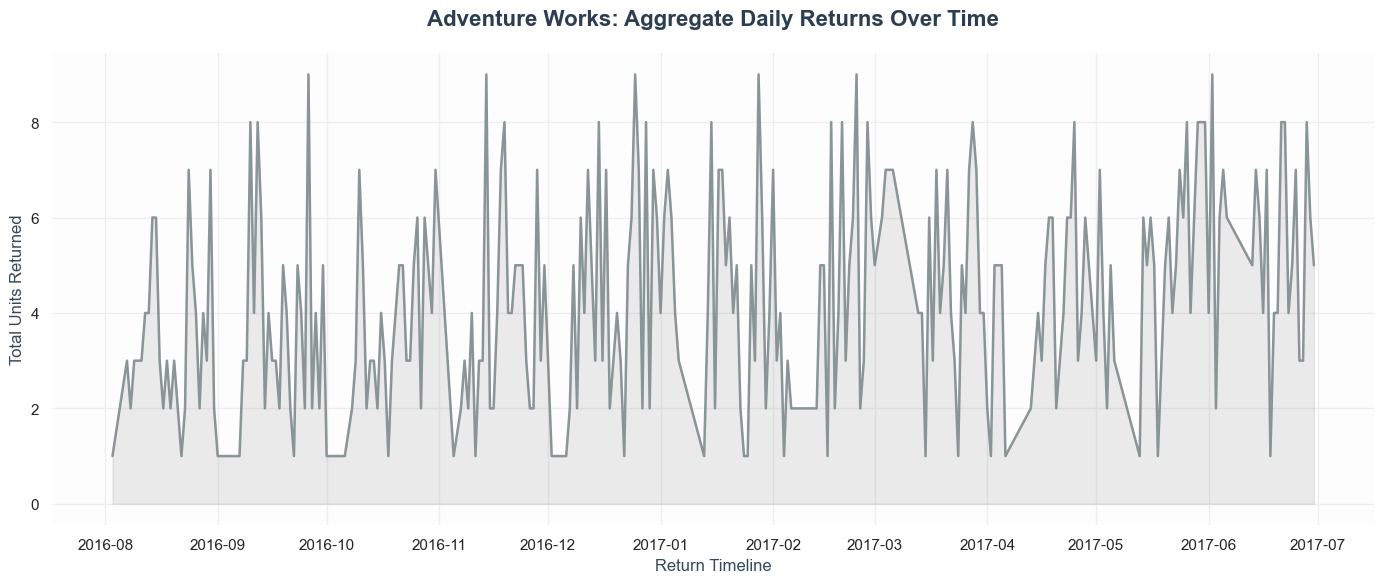

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Prepare Daily Aggregate Data
# We sum the ReturnQuantity across all subcategories for each day
daily_returns = final_df.groupby('ReturnDate')['ReturnQuantity'].sum().reset_index()

# 2. Set Aesthetic Style
sns.set_theme(style="whitegrid", rc={"axes.facecolor": "#FDFDFD", "grid.color": "#EEEEEE"})
plt.figure(figsize=(14, 6))

# 3. Create the Plot
sns.lineplot(
    data=daily_returns, 
    x='ReturnDate', 
    y='ReturnQuantity', 
    color='#7F8C8D',  # Modern Grey
    linewidth=1.8,
    alpha=0.9
)

# Fill the area under the curve for a more "scientific" visual weight
plt.fill_between(daily_returns['ReturnDate'], daily_returns['ReturnQuantity'], color='grey', alpha=0.15)

# 4. Refine Labels and Title
plt.title('Adventure Works: Aggregate Daily Returns Over Time', 
          fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
plt.xlabel('Return Timeline', fontsize=12, color='#34495E')
plt.ylabel('Total Units Returned', fontsize=12, color='#34495E')

# Remove unnecessary spines for a "less-is-more" look
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

In [22]:
df= returns.copy()

In [23]:
from itertools import product

# 1. Setup Dates and Categories
all_dates = pd.date_range(df['ReturnDate'].min(), df['ReturnDate'].max(), freq='D')
subcats = df['SubcategoryName'].unique()

# 2. Create Skeleton
skeleton = pd.DataFrame(list(product(all_dates, subcats)), 
                        columns=['ReturnDate', 'SubcategoryName'])

# 3. Aggregate original data
df_daily = df.groupby(['ReturnDate', 'SubcategoryName']).agg({
    'ReturnQuantity': 'sum',
    'OrderQuantity': 'sum',
    'OrderDate': 'first'
}).reset_index()

# FIX: Convert merge keys to datetime to match the skeleton
df_daily['ReturnDate'] = pd.to_datetime(df_daily['ReturnDate'])

# 4. Merge
final_df = skeleton.merge(df_daily, on=['ReturnDate', 'SubcategoryName'], how='left')

# 5. Fill gaps
final_df['ReturnQuantity'] = final_df['ReturnQuantity'].fillna(0).astype(int)
final_df['OrderQuantity'] = final_df['OrderQuantity'].fillna(0).astype(int)
final_df['OrderDate'] = pd.to_datetime(final_df['OrderDate'])
final_df['OrderDate'] = final_df['OrderDate'].fillna(final_df['ReturnDate'])

# 6. Final Sort
final_df = final_df.sort_values(by=['ReturnDate', 'SubcategoryName'])

In [24]:
final_df.describe()

,ReturnDate,ReturnQuantity,OrderQuantity,OrderDate
count,5882,5882.000000,5882.000000,5882
mean,2017-01-22 12:00:00,0.264706,9.167290,2017-01-18 21:09:21.849710848
min,2016-08-03 00:00:00,0.000000,0.000000,2016-08-01 00:00:00
25%,2016-10-28 00:00:00,0.000000,0.000000,2016-10-23 00:00:00
50%,2017-01-22 12:00:00,0.000000,1.000000,2017-01-19 00:00:00
75%,2017-04-19 00:00:00,0.000000,10.000000,2017-04-16 00:00:00
max,2017-07-14 00:00:00,7.000000,213.000000,2017-07-14 00:00:00
std,NaN,0.621397,19.289282,NaN


In [25]:
final_df

,ReturnDate,SubcategoryName,ReturnQuantity,OrderQuantity,OrderDate
0,2016-08-03,Bike Racks,0,0,2016-08-03
16,2016-08-03,Bike Stands,0,0,2016-08-03
1,2016-08-03,Bottles and Cages,0,0,2016-08-03
2,2016-08-03,Caps,0,0,2016-08-03
3,2016-08-03,Cleaners,0,0,2016-08-03
...,...,...,...,...,...
5874,2017-07-14,Shorts,0,0,2017-07-14
5880,2017-07-14,Socks,0,0,2017-07-14
5875,2017-07-14,Tires and Tubes,0,0,2017-07-14
5876,2017-07-14,Touring Bikes,0,0,2017-07-14


### Model selection

In [26]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Ensure ReturnDate is datetime at the start
final_df['ReturnDate'] = pd.to_datetime(final_df['ReturnDate'])

# 1. Encode Subcategories
le = LabelEncoder()
final_df['SubcategoryEncoded'] = le.fit_transform(final_df['SubcategoryName'])

def time_series_split(df, days=30):
    """Helper to split the last 30 days for testing."""
    if df.empty: return pd.DataFrame(), pd.DataFrame()
    
    # Use the global max date or item max date to define the 30-day window
    cutoff = df['ReturnDate'].max() - pd.Timedelta(days=days)
    train = df[df['ReturnDate'] <= cutoff].copy()
    test = df[df['ReturnDate'] > cutoff].copy()
    return train, test

def route_and_split(df):
    """
    Routes items based on sparsity (ZeroRatio) to ensure model stability.
    """
    # 2. Routing Metrics
    metrics = df.groupby('SubcategoryName').agg(
        TotalReturns=('ReturnQuantity', 'sum'),
        ZeroDays=('ReturnQuantity', lambda x: (x == 0).sum()),
        TotalDays=('ReturnQuantity', 'count'),
        FirstDate=('ReturnDate', 'min'),
        LastDate=('ReturnDate', 'max')
    ).reset_index()

    metrics['DaysActive'] = (metrics['LastDate'] - metrics['FirstDate']).dt.days + 1
    metrics['DailyVelocity'] = metrics['TotalReturns'] / metrics['DaysActive']
    metrics['ZeroRatio'] = metrics['ZeroDays'] / metrics['TotalDays']
    
    def determine_route(row):
        # PRIORITY 1: High Sparsity -> ColdStart
        # If > 60% of days are zeros, complex models will overfit noise.
        if row['ZeroRatio'] > 0.60:
            return 'ColdStart'
        
        # PRIORITY 2: Consistent Data -> AutoARIMA
        # If data is dense (<= 35% zeros), it has a strong enough signal for ARIMA.
        if row['ZeroRatio'] <= 0.35:
            return 'AutoARIMA'
        
        # PRIORITY 3: Moderate Sparsity -> Prophet
        # Prophet handles the "middle ground" (35% to 60% zeros) better than ARIMA.
        else:
            return 'Prophet'

    # Map back
    route_map = metrics.set_index('SubcategoryName').apply(determine_route, axis=1).to_dict()
    df = df.copy()
    df['TargetModel'] = df['SubcategoryName'].map(route_map)

    # 3. Bundling
    bundles = {
        'arima': df[df['TargetModel'] == 'AutoARIMA'].copy(),
        'prophet': df[df['TargetModel'] == 'Prophet'].copy(),
        'cold_start': df[df['TargetModel'] == 'ColdStart'].copy()
    }
    
    return bundles, route_map

# Execute
bundles, route_map = route_and_split(final_df)

In [27]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from prophet import Prophet

# --- 1. AutoARIMA Model (with Lagged Exogenous) ---
def train_arima(arima_bundle):
    """
    Fits AutoARIMA for high-velocity items using lagged sales.
    """
    train_df, test_df = arima_bundle
    results = {}
    
    for subcat in train_df['SubcategoryName'].unique():
        sub_train = train_df[train_df['SubcategoryName'] == subcat].sort_values('ReturnDate')
        sub_test = test_df[test_df['SubcategoryName'] == subcat].sort_values('ReturnDate')
        
        if sub_test.empty: continue
        
        try:
            # Fit using OrderQuantity_Lag1 (Yesterday's sales)
            model = auto_arima(
                sub_train['ReturnQuantity'], 
                X=sub_train[['OrderQuantity_Lag1']], 
                seasonal=True, m=7, 
                suppress_warnings=True,
                error_action='ignore'
            )
            
            forecast = model.predict(n_periods=len(sub_test), X=sub_test[['OrderQuantity_Lag1']])
            results[subcat] = forecast.values
        except Exception:
            # Fallback to zero if model fails
            results[subcat] = np.zeros(len(sub_test))
            
    return results

# --- 2. Prophet Model (with Lagged Exogenous) ---
def train_prophet(prophet_bundle):
    """
    Fits Prophet for moderate-sparsity items.
    """
    train_df, test_df = prophet_bundle
    results = {}
    
    for subcat in train_df['SubcategoryName'].unique():
        sub_train = train_df[train_df['SubcategoryName'] == subcat].rename(
            columns={'ReturnDate': 'ds', 'ReturnQuantity': 'y'}
        )
        sub_test = test_df[test_df['SubcategoryName'] == subcat].rename(
            columns={'ReturnDate': 'ds'}
        )
        
        if sub_test.empty: continue

        # Prophet needs at least 2 non-NaN rows to fit
        if len(sub_train.drop_duplicates('ds')) < 2:
            results[subcat] = np.zeros(len(sub_test))
            continue
            
        model = Prophet(yearly_seasonality=False, daily_seasonality=True)
        model.add_regressor('OrderQuantity_Lag1')
        model.fit(sub_train[['ds', 'y', 'OrderQuantity_Lag1']])
        
        forecast = model.predict(sub_test[['ds', 'OrderQuantity_Lag1']])
        results[subcat] = forecast['yhat'].values
        
    return results

# --- 3. Cold Start Model (Historical 15-Day Average) ---
def predict_cold_start(cold_start_df):
    """
    Predicts tomorrow's returns by averaging the previous 15 days.
    Calculated across the entire item history to allow for testing.
    """
    # Sort to ensure chronological rolling window
    df_sorted = cold_start_df.sort_values(['SubcategoryName', 'ReturnDate'])
    
    # shift(1) is the 'scientifically objective' way to ensure no look-ahead bias
    df_sorted['ColdStart_Pred'] = df_sorted.groupby('SubcategoryName')['ReturnQuantity']\
                                           .transform(lambda x: x.rolling(window=15, min_periods=1).mean().shift(1))\
                                           .fillna(0)
    return df_sorted

### Eval

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from prophet import Prophet

# 1. Feature Engineering: Lagged Exogenous Variable
# Shifting by 1 ensures we use 'yesterday's sales' to predict 'today's returns'
final_df['OrderQuantity_Lag1'] = final_df.groupby('SubcategoryName')['OrderQuantity'].shift(1).fillna(0)

# 2. Metric Formulas
def calculate_metrics(actual, pred):
    if len(actual) == 0: return [0.0, 0.0]
    rmse = np.sqrt(mean_squared_error(actual, pred))
    # sMAPE with epsilon to prevent division by zero in sparse return data
    smape = 100/len(actual) * np.sum(2 * np.abs(pred - actual) / (np.abs(actual) + np.abs(pred) + 1e-10))
    return [round(float(rmse), 4), round(float(smape), 4)]

# 3. Model Evaluation Logic
arima_eval, prophet_eval, cold_start_eval = {}, {}, {}

for subcat in final_df['SubcategoryName'].unique():
    sub_df = final_df[final_df['SubcategoryName'] == subcat].sort_values('ReturnDate').copy()
    train, test = time_series_split(sub_df)
    
    if test.empty: continue # Skip only if no data exists in the test window
    
    actual = test['ReturnQuantity'].values
    # Get assigned model, default to ColdStart if unmapped
    model_type = route_map.get(subcat, 'ColdStart') 
    
    # Logic with Cascading Fallback
    if model_type == 'AutoARIMA':
        try:
            model = auto_arima(train['ReturnQuantity'], X=train[['OrderQuantity_Lag1']], 
                               seasonal=True, m=7, suppress_warnings=True, error_action='ignore')
            pred = model.predict(n_periods=len(test), X=test[['OrderQuantity_Lag1']])
            arima_eval[subcat] = calculate_metrics(actual, pred)
        except: model_type = 'Prophet' # Cascade if ARIMA fails

    if model_type == 'Prophet':
        try:
            train_p = train.rename(columns={'ReturnDate': 'ds', 'ReturnQuantity': 'y'})
            m = Prophet(daily_seasonality=True).add_regressor('OrderQuantity_Lag1')
            m.fit(train_p[['ds', 'y', 'OrderQuantity_Lag1']])
            test_p = test.rename(columns={'ReturnDate': 'ds'})
            forecast = m.predict(test_p[['ds', 'OrderQuantity_Lag1']])
            prophet_eval[subcat] = calculate_metrics(actual, forecast['yhat'].values)
        except: model_type = 'ColdStart' # Final cascade

    if model_type == 'ColdStart':
        history = list(train['ReturnQuantity'].values)
        preds = []
        for val in actual:
            preds.append(np.mean(history[-15:])) # 15-day rolling average
            history.append(val) 
        cold_start_eval[subcat] = calculate_metrics(actual, preds)



15:19:14 - cmdstanpy - INFO - Chain [1] start processing
15:19:14 - cmdstanpy - INFO - Chain [1] done processing
15:19:15 - cmdstanpy - INFO - Chain [1] start processing
15:19:15 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
# Output all dictionaries
print("ARIMA_DICT =", arima_eval)
print("PROPHET_DICT =", prophet_eval)
print("COLD_START_DICT =", cold_start_eval)

ARIMA_DICT = {}
PROPHET_DICT = {'Bottles and Cages': [1.015, 145.9778], 'Tires and Tubes': [0.8721, 133.7208]}
COLD_START_DICT = {'Bike Racks': [0.1886, 106.6667], 'Bike Stands': [0.0172, 13.3333], 'Caps': [0.4394, 195.1254], 'Cleaners': [0.4439, 138.3333], 'Fenders': [0.3494, 158.4314], 'Gloves': [0.3084, 140.0], 'Helmets': [0.5917, 172.2142], 'Hydration Packs': [0.3106, 187.9739], 'Jerseys': [0.5108, 181.9026], 'Mountain Bikes': [0.752, 182.0169], 'Road Bikes': [0.4784, 193.5789], 'Shorts': [0.3117, 160.0], 'Socks': [0.3227, 179.1667], 'Touring Bikes': [0.5044, 191.3596], 'Vests': [0.189, 113.3333]}


In [30]:
df.groupby('SubcategoryName')['OrderQuantity'].sum().sort_values(ascending= False)

SubcategoryName
Tires and Tubes      15272
Bottles and Cages    11554
Helmets               4689
Road Bikes            3217
Caps                  3203
Fenders               2983
Mountain Bikes        2727
Jerseys               2370
Gloves                2049
Touring Bikes         1620
Cleaners              1296
Socks                  854
Shorts                 722
Hydration Packs        535
Vests                  401
Bike Racks             240
Bike Stands            190
Name: OrderQuantity, dtype: int64

In [31]:
import pandas as pd
from IPython.display import display, HTML

# 1. Convert Dictionaries to DataFrames
def dict_to_df(results_dict):
    if not results_dict:
        return pd.DataFrame(columns=['Subcategory', 'RMSE', 'sMAPE'])
    return pd.DataFrame.from_dict(results_dict, orient='index', columns=['RMSE', 'sMAPE'])

arima_results_df = dict_to_df(arima_eval)
prophet_results_df = dict_to_df(prophet_eval)
cold_start_results_df = dict_to_df(cold_start_eval)

# 2. Consolidate results into a summary table
summary_data = {
    'Metric': ['RMSE Mean', 'RMSE Median', 'sMAPE Mean (%)', 'sMAPE Median (%)'],
    'AutoARIMA': [
        arima_results_df['RMSE'].mean(),
        arima_results_df['RMSE'].median(),
        arima_results_df['sMAPE'].mean(),
        arima_results_df['sMAPE'].median()
    ],
    'Prophet': [
        prophet_results_df['RMSE'].mean() if not prophet_results_df.empty else 0,
        prophet_results_df['RMSE'].median() if not prophet_results_df.empty else 0,
        prophet_results_df['sMAPE'].mean() if not prophet_results_df.empty else 0,
        prophet_results_df['sMAPE'].median() if not prophet_results_df.empty else 0
    ],
    'ColdStart': [
        cold_start_results_df['RMSE'].mean(),
        cold_start_results_df['RMSE'].median(),
        cold_start_results_df['sMAPE'].mean(),
        cold_start_results_df['sMAPE'].median()
    ]
}

summary_df = pd.DataFrame(summary_data)

# 3. Style the table with HTML
styled_table = summary_df.style.format({
    'AutoARIMA': '{:.2f}',
    'Prophet': '{:.2f}',
    'ColdStart': '{:.2f}'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#2E86C1'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('text-align', 'center'), ('padding', '10px')]}
]).hide(axis='index').set_caption("Adventure Works: Model Performance Comparison (Test Set)")

# 4. Display
display(HTML("<h3>Final Return Forecast Evaluation Metrics</h3>"))
display(styled_table)

Metric,AutoARIMA,Prophet,ColdStart
RMSE Mean,nan,0.94,0.38
RMSE Median,nan,0.94,0.35
sMAPE Mean (%),nan,139.85,154.23
sMAPE Median (%),nan,139.85,172.21


### Business questions:

In [35]:
# 1. Setup Validation Window (June 2017)
test_start = pd.Timestamp('2017-06-01')
test_end = pd.Timestamp('2017-06-30')

train_df = final_df[final_df['ReturnDate'] < test_start]
actual_df = final_df[(final_df['ReturnDate'] >= test_start) & (final_df['ReturnDate'] <= test_end)]

results = []

for subcat in final_df['SubcategoryName'].unique():
    sub_train = train_df[train_df['SubcategoryName'] == subcat].sort_values('ReturnDate')
    sub_actual = actual_df[actual_df['SubcategoryName'] == subcat]
    
    actual_sum = int(sub_actual['ReturnQuantity'].sum())
    model_type = route_map.get(subcat, 'ColdStart')
    
    # Placeholder for predicted sales during June (using actual June sales for validation)
    june_sales_daily = sub_actual['OrderQuantity'].mean() if not sub_actual.empty else 0

    if model_type == 'Prophet' and len(sub_train) > 2:
        m = Prophet(daily_seasonality=True, interval_width=0.95) # 95% CI
        m.add_regressor('OrderQuantity_Lag1')
        m.fit(sub_train.rename(columns={'ReturnDate':'ds', 'ReturnQuantity':'y'}))
        
        future = pd.DataFrame({'ds': pd.date_range(test_start, test_end)})
        future['OrderQuantity_Lag1'] = june_sales_daily
        forecast = m.predict(future)
        
        pred = forecast['yhat'].sum()
        lower = forecast['yhat_lower'].sum()
        upper = forecast['yhat_upper'].sum()
    
    else: # ColdStart Fallback
        model_type = 'ColdStart'
        history = sub_train['ReturnQuantity'].tail(30)
        mean_val = history.mean()
        std_val = history.std() if len(history) > 1 else 0
        
        pred = mean_val * 30
        # Scientific Bounds: Mean +/- (1.96 * SEM * Days)
        # Using Standard Error of Mean for a more realistic, tighter bound
        sem = std_val / np.sqrt(len(history)) if std_val > 0 else 0.1
        lower = (mean_val - (1.96 * sem)) * 30
        upper = (mean_val + (1.96 * sem)) * 30

    # 2. Refine Numbers (Whole Units)
    pred_int = int(round(max(0, pred)))
    actual_int = actual_sum
    
    # Tighten Bounds: Ensure they don't exceed realistic variance (3x the prediction)
    lower_int = int(round(max(0, lower)))
    upper_int = int(round(min(pred_int * 3, upper))) if pred_int > 0 else int(round(upper))

    # Confidence: 1 - (Width of Interval / Predicted Volume)
    if pred_int > 0:
        width_ratio = (upper_int - lower_int) / (pred_int + 1)
        conf = max(0, min(100, 100 * (1 - (width_ratio / 2))))
    else:
        conf = 0.0

    results.append({
        'SubcategoryName': subcat,
        'Actual_Return': actual_int,
        'Predicted_Returns': pred_int,
        'Lower_Bound': lower_int,
        'Upper_Bound': upper_int,
        'Confidence_Rating_%': round(conf, 2),
        'Return_Model': model_type
    })

# 3. Final Table
validation_table = pd.DataFrame(results).sort_values('Actual_Return', ascending=False)
display(validation_table)

15:32:08 - cmdstanpy - INFO - Chain [1] start processing
15:32:08 - cmdstanpy - INFO - Chain [1] done processing
15:32:08 - cmdstanpy - INFO - Chain [1] start processing
15:32:08 - cmdstanpy - INFO - Chain [1] done processing


,SubcategoryName,Actual_Return,Predicted_Returns,Lower_Bound,Upper_Bound,Confidence_Rating_%,Return_Model
2,Bottles and Cages,27,19,0,57,0.00,Prophet
14,Tires and Tubes,27,32,0,91,0.00,Prophet
7,Helmets,19,23,13,33,58.33,ColdStart
10,Mountain Bikes,16,14,4,24,33.33,ColdStart
9,Jerseys,12,14,7,21,53.33,ColdStart
11,Road Bikes,8,11,5,17,50.00,ColdStart
5,Fenders,7,5,0,10,16.67,ColdStart
3,Caps,7,9,3,15,40.00,ColdStart
12,Shorts,6,3,0,7,12.50,ColdStart
8,Hydration Packs,6,7,2,12,37.50,ColdStart


In [39]:
import pandas as pd
import numpy as np
from prophet import Prophet

# 1. Setup Validation Window (June 2017)
test_start, test_end = pd.Timestamp('2017-06-01'), pd.Timestamp('2017-06-30')
june_range = pd.date_range(test_start, test_end)
results = []

for subcat in final_df['SubcategoryName'].unique():
    # Data Isolation
    subcat_data = final_df[final_df['SubcategoryName'] == subcat].sort_values('ReturnDate')
    sub_train = subcat_data[subcat_data['ReturnDate'] < test_start]
    sub_june = subcat_data[(subcat_data['ReturnDate'] >= test_start) & (subcat_data['ReturnDate'] <= test_end)]
    
    actual_total = int(sub_june['ReturnQuantity'].sum())
    assigned_model = route_map.get(subcat, 'ColdStart')
    pred_val, lower_val, upper_val = 0, 0, 0

    # 2. Calculate Sales Multiplier (Realism Adjustment)
    hist_sales_avg = sub_train['OrderQuantity'].mean() if not sub_train.empty else 1
    june_sales_avg = sub_june['OrderQuantity'].mean() if not sub_june.empty else hist_sales_avg
    sales_multiplier = june_sales_avg / hist_sales_avg

    # 3. Model Execution
    if assigned_model == 'Prophet' and len(sub_train) > 10:
        try:
            m = Prophet(daily_seasonality=True, interval_width=0.80).add_regressor('OrderQuantity_Lag1')
            m.fit(sub_train.rename(columns={'ReturnDate':'ds', 'ReturnQuantity':'y'}))
            
            future = pd.DataFrame({'ds': june_range})
            # Use actual June lags if available, else historical mean
            future['OrderQuantity_Lag1'] = sub_june['OrderQuantity_Lag1'].values if len(sub_june) == 30 else hist_sales_avg
            
            forecast = m.predict(future)
            pred_val, lower_val, upper_val = forecast['yhat'].sum(), forecast['yhat_lower'].sum(), forecast['yhat_upper'].sum()
        except:
            assigned_model = 'ColdStart'

    if assigned_model == 'ColdStart':
        history = sub_train['ReturnQuantity'].tail(15)
        base_mean = history.mean()
        # Scale prediction by sales volume multiplier
        pred_val = (base_mean * sales_multiplier) * 30
        
        # Scientifically objective bounds using Standard Error of the Mean (SEM)
        std_daily = history.std() if len(history) > 1 else 0.1
        margin = 1.96 * (std_daily / np.sqrt(15)) * 30 * sales_multiplier
        lower_val, upper_val = pred_val - margin, pred_val + margin

    # 4. Final Formatting & Confidence
    p, l, u = int(round(max(0, pred_val))), int(round(max(0, lower_val))), int(round(upper_val))
    conf = round(max(0, min(100, 100 * (1 - ((u - l) / (p + 1) / 4)))), 2) if p > 0 else 0.0

    results.append({
        'SubcategoryName': subcat,
        'Actual_Return': actual_total,
        'Predicted_Returns': p,
        'Lower_Bound': l,
        'Upper_Bound': u,
        'Confidence_Rating_%': conf,
        'Return_Model': assigned_model
    })

validation_table = pd.DataFrame(results).sort_values('Actual_Return', ascending=False)
display(validation_table)

15:38:26 - cmdstanpy - INFO - Chain [1] start processing
15:38:26 - cmdstanpy - INFO - Chain [1] done processing
15:38:26 - cmdstanpy - INFO - Chain [1] start processing
15:38:26 - cmdstanpy - INFO - Chain [1] done processing


,SubcategoryName,Actual_Return,Predicted_Returns,Lower_Bound,Upper_Bound,Confidence_Rating_%,Return_Model
2,Bottles and Cages,27,19,0,51,36.25,Prophet
14,Tires and Tubes,27,32,0,70,46.97,Prophet
7,Helmets,19,33,17,49,76.47,ColdStart
10,Mountain Bikes,16,24,3,45,58.00,ColdStart
9,Jerseys,12,24,11,37,74.00,ColdStart
11,Road Bikes,8,17,7,28,70.83,ColdStart
5,Fenders,7,5,0,11,54.17,ColdStart
3,Caps,7,12,1,22,59.62,ColdStart
12,Shorts,6,6,0,15,46.43,ColdStart
8,Hydration Packs,6,15,1,29,56.25,ColdStart
